In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, minmax_scale
from operator import itemgetter

In [2]:
shuttle = pd.read_csv('../input/shuttleX2.csv', header=None, sep=',', quoting=False).astype('float64')
shuttle_y = pd.read_csv('../input/shuttleY.csv', header=None)
shuttle.head()

,0,1,2,3,4,5,6,7,8
0,50.0,21.0,77.0,0.0,28.0,0.0,27.0,48.0,22.0
1,53.0,0.0,82.0,0.0,52.0,-5.0,29.0,30.0,2.0
2,37.0,0.0,76.0,0.0,28.0,18.0,40.0,48.0,8.0
3,37.0,0.0,79.0,0.0,34.0,-26.0,43.0,46.0,2.0
4,85.0,0.0,88.0,-4.0,6.0,1.0,3.0,83.0,80.0


In [3]:
shuttle = scale(shuttle)

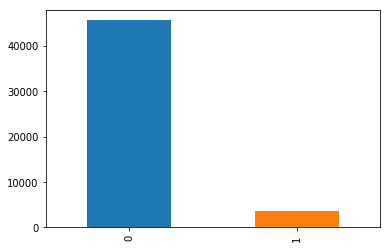

In [4]:
shuttle_y.iloc[:, 0].value_counts().plot.bar()
plt.savefig('img.png')
plt.show()

In [5]:
shuttle_y[0].value_counts()

0    45586
1     3511
Name: 0, dtype: int64

In [6]:
gamma_values, err_values_gamma = [], []
for g in np.linspace(0.0000015, 0.00015, 10):
    onesvm = OneClassSVM(nu= shuttle_y.mean(), gamma=g)
    onesvm.fit(shuttle)
    yhat = onesvm.predict(shuttle)
    yhat = ((yhat - 1) * -1) / 2
    acc = accuracy_score(shuttle_y, yhat)
    err = 1 - acc
    gamma_values.append(g)
    err_values_gamma.append(err)

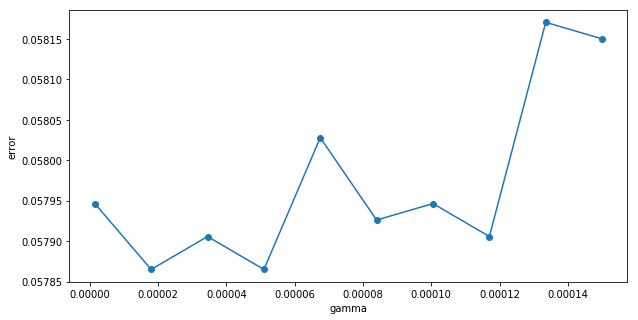

In [7]:
plt.subplots(figsize=(10, 5))
plt.plot(gamma_values, err_values_gamma, 'o-')
plt.xlabel('gamma')
plt.ylabel('error')
plt.show()

In [8]:
max(err_values_gamma), min(err_values_gamma)

(0.05817056031936774, 0.05786504267063164)

In [9]:
## Unsupervised (OneClassSVM)

In [10]:
onesvm = OneClassSVM(nu = shuttle_y.mean(), gamma=0.00002)
onesvm.fit(shuttle)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=2e-05, kernel='rbf',
      max_iter=-1,
      nu=0    0.071511
dtype: float64, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [11]:
yhat = onesvm.predict(shuttle)
yhat = ((yhat - 1) * -1) / 2

In [12]:
print(accuracy_score(shuttle_y, yhat))
print(confusion_matrix(shuttle_y, yhat))
print(classification_report(shuttle_y, yhat))

0.9420738537996212
[[44164  1422]
 [ 1422  2089]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     45586
           1       0.59      0.59      0.59      3511

   micro avg       0.94      0.94      0.94     49097
   macro avg       0.78      0.78      0.78     49097
weighted avg       0.94      0.94      0.94     49097



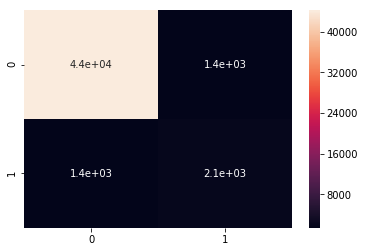

In [13]:
sns.heatmap(confusion_matrix(shuttle_y, yhat), annot=True)
plt.savefig('heatmap_shuttle.png')

In [14]:
tsne = TSNE(n_components=2)
shuttle2 = tsne.fit_transform(shuttle)

In [15]:
shuttle2 = pd.DataFrame(shuttle2, columns=['x','y'])
shuttle2['ytrue'] = shuttle_y[0]
shuttle2['yhat']  = yhat
shuttle_y.shape, shuttle2.shape

((49097, 1), (49097, 4))

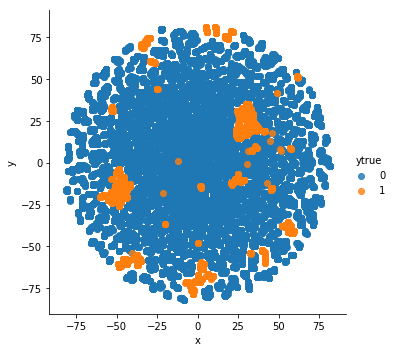

In [16]:
sns.lmplot(data=shuttle2, x='x', y='y', hue='ytrue', fit_reg=False)

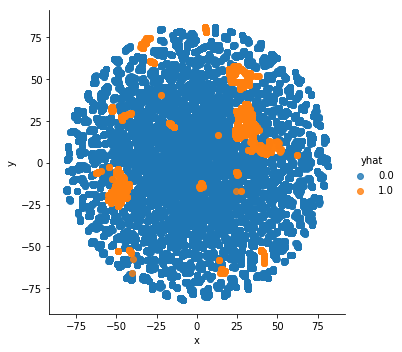

In [17]:
sns.lmplot(data=shuttle2, x='x', y='y', hue='yhat', fit_reg=False)

In [18]:
## Supervised (SVC)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(shuttle, shuttle_y, test_size=0.3, shuffle=False, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=13)
svm = SVC(gamma = 'auto')
svm.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
gamma_values, err_gamma = [], []
for g in np.linspace(0.000005, 0.0005, 10):
    svm = SVC(gamma=g, C=1.0)
    svm.fit(X_train, y_train.values.ravel())
    yhat = svm.predict(X_val)
    acc = accuracy_score(y_val, yhat)
    err = 1 - acc
    gamma_values.append(g)
    err_gamma.append(err)

In [21]:
gamma_c_values, err_gamma_c = [], []
for g in np.linspace(10e-5, 0.01, 5):
    for c in np.linspace(0.4, 10, 10):
        svm = SVC(gamma=g, C=c)
        svm.fit(X_train, y_train.values.ravel())
        yhat = svm.predict(X_val)
        acc = accuracy_score(y_val, yhat)
        err = 1 - acc
        gamma_c_values.append((g,c))
        err_gamma_c.append(err)

In [22]:
gamma_v = list(map(itemgetter(0), gamma_c_values))
c_v = list(map(itemgetter(1), gamma_c_values))

Text(0.5, 0, 'err')

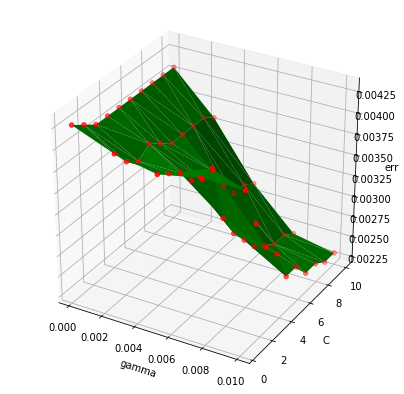

In [23]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(gamma_v, c_v, err_gamma_c, shade=True, color='green')
ax.scatter(gamma_v, c_v, err_gamma_c, color='red')
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('err')

In [24]:
max(err_gamma_c), min(err_gamma_c)

(0.004267287363010408, 0.002327611288914788)

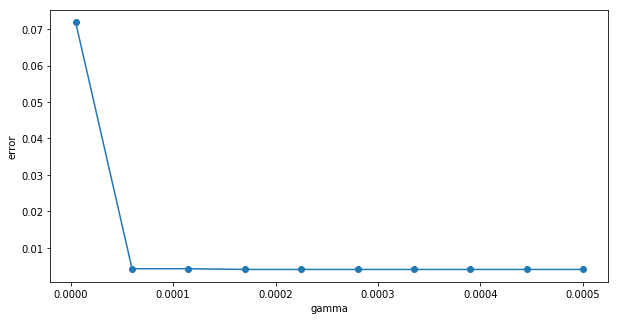

In [25]:
plt.subplots(figsize=(10, 5))
plt.plot(gamma_values, err_gamma, 'o-')
plt.xlabel('gamma')
plt.ylabel('error')
plt.show()

In [26]:
max(err_gamma), min(err_gamma)

(0.07186499854524298, 0.004073319755600768)

In [27]:
best_gamma_c = min(zip(gamma_c_values, err_gamma_c), key=lambda p: p[1])[0]
svm = SVC(gamma=best_gamma_c[0], C=best_gamma_c[1])
svm.fit(X_train, y_train.values.ravel())

SVC(C=8.933333333333334, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
yhat_shuttle = svm.predict(X_test)

In [29]:
print(accuracy_score(y_test, yhat_shuttle))
print(confusion_matrix(y_test, yhat_shuttle))
print(classification_report(y_test, yhat_shuttle))

0.9977596741344196
[[13693     1]
 [   32  1004]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13694
           1       1.00      0.97      0.98      1036

   micro avg       1.00      1.00      1.00     14730
   macro avg       1.00      0.98      0.99     14730
weighted avg       1.00      1.00      1.00     14730



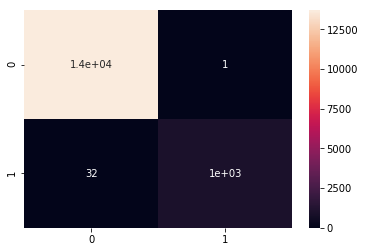

In [30]:
sns.heatmap(confusion_matrix(y_test, yhat_shuttle), annot=True)
plt.savefig('heatmap_shuttle.png')

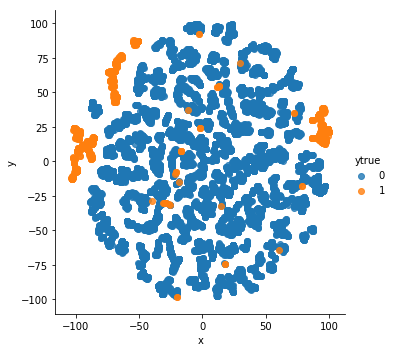

In [31]:
test_shuttle2 = TSNE(n_components=2).fit_transform(X_test)
test_shuttle2 = pd.DataFrame(test_shuttle2, columns=['x','y'])
test_shuttle2['ytrue'] = y_test.values
test_shuttle2['yhat'] = yhat_shuttle
sns.lmplot(data=test_shuttle2, x='x', y='y', hue='ytrue', fit_reg=False)

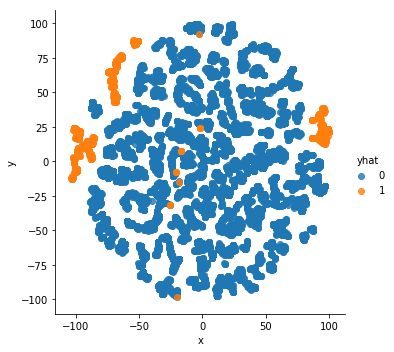

In [32]:
sns.lmplot(data=test_shuttle2, x='x', y='y', hue='yhat', fit_reg=False)